In [149]:
import pandas as pd
import numpy as np
import yaml
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.fft import fft
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, PowerTransformer, RobustScaler
import openpyxl
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score,precision_score, f1_score, mean_squared_error
import xgboost as xgb
import optuna
import talib
import json
import pickle


In [3]:
def load_yaml(file):
    import yaml
    with open(file, 'r') as f:
        config = yaml.safe_load(f)
    return config
    



In [119]:
config = load_yaml('../config_Reg.yaml')

In [5]:
#trading_data = pd.read_excel(config['data_excel_path'], sheet_name='Data_Basic')
#trading_data.count()
all_trading_data_dfs = []
sheet_names = ['5minData11-6-2014', '5minData12-17-2019']
for sheet in sheet_names:
    temp_df = pd.read_excel(config['all_data_excel_path'], sheet_name=sheet)
    all_trading_data_dfs.append(temp_df)
all_trading_data = pd.concat(all_trading_data_dfs, ignore_index=True)

# Load 5 min data
all_trading_data['Date'] = pd.to_datetime(all_trading_data['Date'])


In [127]:
##### Set the Date Start and End for the filtering of trading data

train_start_date = pd.to_datetime('2023-12-01')
train_end_date = pd.to_datetime('2023-12-31')

trading_data_raw = all_trading_data[(all_trading_data['Date'] >= train_start_date) & (all_trading_data['Date'] <= train_end_date)]
trading_data_raw = trading_data_raw.reset_index(drop=True)
trading_data_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1560 non-null   datetime64[ns]
 1   Symbol  1560 non-null   object        
 2   Open    1560 non-null   float64       
 3   High    1560 non-null   float64       
 4   Low     1560 non-null   float64       
 5   Close   1560 non-null   float64       
 6   Volume  1560 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 85.4+ KB


In [61]:
def calculate_bollinger_bands(data, window_size, num_std_dev):
    rolling_mean = data['Close'].rolling(window=window_size).mean()
    rolling_std = data['Close'].rolling(window=window_size).std()
    data['BOLLBU'] = rolling_mean + (rolling_std * num_std_dev)
    data['BOLLBM'] = rolling_mean
    data['BOLLBL'] = rolling_mean - (rolling_std * num_std_dev)
    
    return data

def calculate_donchn_bands(data, window_size):
    data['DONCH_U'] = data['High'].rolling(window=window_size).max()
    data['DONCH_L'] = data['Low'].rolling(window=window_size).min()
    
    return data
    
def calculate_tchr(data):
    period = config['tchr_period']
    retracement = config['tchr_retracement']
    adj = config['tchr_adj']
    range = config['tchr_range']

    if range == 'highlow':
        data['TCHR_U'] = talib.MAX(data['High'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Low'], timeperiod=period) - adj
    elif range == 'close':
        data['TCHR_U'] = talib.MAX(data['Close'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Close'], timeperiod=period) - adj
    
    #calculate retracement
    if retracement == "long":
        data['TCHR'] = (data['Close'] - data['TCHR_L']) / (data['TCHR_U'] - data['TCHR_L'])
    elif retracement == "short":
        data['TCHR'] = (data['TCHR_U'] - data['Close']) / (data['TCHR_U'] - data['TCHR_L'])
    
    return data
    
def calculate_adwm(data):
    period = config['adwm_period']
    data['Previous_Close']= data['Close'].shift(1)
    data['TRH'] = data[['High', 'Previous_Close']].max(axis=1)
    data['TRL'] = data[['Low', 'Previous_Close']].min(axis=1)

    data['ADWM_AD'] = 0.0
    data.loc[data['Close'] > data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRL'])
    data.loc[data['Close'] < data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRH'])

    data['ADWM'] = data['ADWM_AD']

    data['ADWMMA'] = data['ADWM'].rolling(window=period).mean()

    return data

def calculate_si(row, prev_row, limit):
    if pd.isna(prev_row['Close']):
        return 0
    c = row['Close']
    c_prev = prev_row['Close']
    o = row['Open']
    o_prev = prev_row['Open']
    return (50 * ((c - c_prev) + (0.5 * (c - o)) + (0.25 * (c_prev - o_prev))) / limit)

def calculate_WASI(data):
    wasi_limit = config['wasi_limit']
    data['SI'] = data.apply(lambda row: calculate_si(row, data.shift(1).loc[row.name], wasi_limit), axis=1)
    data['WASI'] = data['SI']
    return data

def calculate_ATR(data):
    atr_period = config['atr_period']
    atr_ma = config['atr_ma']
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=atr_period)
    data['ADJATR'] = talib.SMA(data['ATR'], timeperiod=atr_ma)
    return data


def compute_fourier_df(value_series, n_components=10):
    fft_result = np.fft.fft(value_series)
    real = fft_result.real[:n_components]
    imag = fft_result.imag[:n_components]
    mag = np.abs(fft_result)[:n_components]

    '''
    real_min, real_max = real.min(), real.max()
    imag_min, imag_max = imag.min(), imag.max()
    mag_min, mag_max = mag.min(), mag.max()
    if real_max > real_min:
        real = (real - real_min) / (real_max - real_min)
    else:
        real = np.full_like(real, 0.5)
    
    if imag_max > imag_min:
        imag = (imag - imag_min) / (imag_max - imag_min)
    else:
        imag = np.full_like(imag, 0.5)
    
    if mag_max > mag_min:
        mag = (mag - mag_min) / (mag_max - mag_min)
    else:
        mag = np.full_like(mag, 0.5)
    '''
    return real, imag, mag

    

In [47]:
fourier_lookback_window = config['fourier_lookback_window']
fourier_n_components = config['fourier_n_components']
raw_features_g1 = config['raw_features_g1'].split(',')

#g2 is the other features. need to use standard scaler for this
raw_features_g2 = config['raw_features_g2'].split(',')

#g3 is volume features. need to use min max scaler separately
raw_features_g3 = config['raw_features_g3'].split(',')

raw_features_g4 = config['raw_features_g4'].split(',')

In [78]:
def add_new_features_df(data):
    global fourier_lookback_window
    global fourier_n_components
    global raw_features_g1
    global raw_features_g2
    global raw_features_g3
    global raw_features_g4
    data['Date'] = pd.to_datetime(data['Date'])
    #print(f"bolband period : {config['bolband_period']}")
    bolband_period = config['bolband_period']
    bolband_width = config['bolband_width']
    upper, middle, lower = talib.BBANDS(data['Close'], timeperiod=bolband_period, nbdevup=bolband_width, nbdevdn=bolband_width, matype=0)
    data['BOLLBU'] = upper
    data['BOLLBM'] = middle
    data['BOLLBL'] = lower
    #data = calculate_bollinger_bands(data, int(config['bolband_period']), int(config['bolband_width']))

    # Calculate DONCHN Bands
    donchn_period = config['donchn_period']
    data['DONUP'] = talib.MAX(data['High'], timeperiod=donchn_period)

    data['DONLOW'] = talib.MIN(data['Low'], timeperiod=donchn_period)

    data['DONMID'] = (data['DONLOW'] + data['DONUP']) / 2

    data['MA20'] = talib.SMA(data['Close'], timeperiod=20)

    data['MA50'] = talib.SMA(data['Close'], timeperiod=50)

    data['MA100'] = talib.SMA(data['Close'], timeperiod=100)

    data['EMA20'] = talib.EMA(data['Close'], timeperiod=20)

    # Calculate the pivot points
    data['PVPT'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['PVPTR1'] = (2 * data['PVPT']) - data['Low']

    data['PVPTR2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTR3'] = data['High'] + 2 * (data['PVPT'] - data['Low'])

    data['PVPTS1'] = (2 * data['PVPT']) - data['High']

    data['PVPTS2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTS3'] = data['Low'] - 2 * (data['High'] - data['PVPT'])

    data = calculate_tchr(data)

    data = calculate_adwm(data)

    data = calculate_WASI(data)

    volume_ma_period = config['volume_ma_period']

    data['VOLMA'] = talib.SMA(data['Volume'], timeperiod=volume_ma_period)

    data = calculate_ATR(data)

    data['DayofWeek'] = data['Date'].dt.dayofweek

    data['DayofWeek'] = data['DayofWeek'].astype('category')

    # Add fourier columns to the df
    for i in range(fourier_n_components):
        data[f'fourier_real_{i+1}'] = np.nan
        data[f'fourier_imag_{i+1}'] = np.nan
        data[f'fourier_mag_{i+1}'] = np.nan

    features = []
    epsilon = 1e-5
    #print(f"fourier window - 1 : {fourier_lookback_window - 1}")
    for i in range(len(data)):
        if i >= fourier_lookback_window - 1:
            #print("entered point 1")
            close_window = data['Close'].iloc[i - fourier_lookback_window + 1: i + 1].values
            real, imag, mag = compute_fourier_df(close_window, n_components=fourier_n_components)

            for j in range(fourier_n_components):
                data.loc[i, f'fourier_real_{j+1}'] = real[j]
                data.loc[i, f'fourier_imag_{j+1}'] = imag[j]
                data.loc[i, f'fourier_mag_{j+1}'] = mag[j]
    
    # Apply min max scaling to the fouorier columns separately for real, imag and mag 
    #real_cols = [col for col in data.columns if col.startswith("fourier_real")]
    #imag_cols = [col for col in data.columns if col.startswith("fourier_imag")]
    #mag_cols = [col for col in data.columns if col.startswith("fourier_mag")]



    # Add the time of day feature to the trading data

    # Define max time of day in minutes
    MAX_TIME_MINUTES = 1440
    data['Minutes_Passed'] = (data['Date'].dt.hour* 60) + data['Date'].dt.minute
    #invalid_Rows = data[data['Minutes_Passed'].isna() | data['Minutes_Passed'].isin([np.inf, -np.inf])]
    #print(f"Invalid rows count : {invalid_Rows.shape[0]}")
    #print(invalid_Rows.head(10))
    data['TimeOfDay_Group'] = (data['Minutes_Passed'] // 5).astype('int')
    data['Sine_TimeOfDay'] = np.sin(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Cosine_TimeOfDay'] = np.cos(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    #data['Take_Profit_Level'] = (data['Close'] * config['atr_multiplier'] * data['ADJATR'])
    #print(f"Last row after adding features : ")
    #print(data.tail())
    return data


In [103]:

def calculate_label(data):

# Define the threshold for buy and sell signals
    buy_penalties = []
    sell_penalties = []

    max_highs = []
    min_lows = []
    n=config['bars_no_to_wait']

    for i in range(len(data)):
        forward_window = data.iloc[i+1:n+i+1]

        if len(forward_window) < n:
            max_highs.append(np.nan)
            min_lows.append(np.nan)
            buy_penalties.append(np.nan)
            sell_penalties.append(np.nan)
            continue

        max_high = forward_window['High'].max()
        min_low = forward_window['Low'].min()

        buy_penalty = 0
        sell_penalty = 0
        prev_close = data.iloc[i]['Close']

        for j in range(len(forward_window)):
            current_close = forward_window.iloc[j]['Close']

            if current_close < prev_close:
                buy_penalty += (prev_close - current_close)
            elif current_close > prev_close:
                sell_penalty += (current_close - prev_close)

            prev_close = current_close
        max_high = max(0, max_high - data.iloc[i]['Close'])
        min_low = max(0, data.iloc[i]['Close'] - min_low)
        max_highs.append(max_high)
        min_lows.append(min_low)
        buy_penalties.append(buy_penalty)
        sell_penalties.append(sell_penalty)

    data['Max_High_N'] = max_highs
    data['Min_Low_N'] = min_lows
    data['Buy_Penalty'] = buy_penalties
    data['Sell_Penalty'] = sell_penalties

    # Scale penalties to avoid extreme scaled values
    max_buy_penalty = max(abs(data['Buy_Penalty'].max()),1)
    max_sell_penalty = max(abs(data['Sell_Penalty'].max()),1)

    data['Scaled_Buy_Penalty'] = data['Buy_Penalty'] / max_buy_penalty * (data['Max_High_N'])
    data['Scaled_Sell_Penalty'] = data['Sell_Penalty'] / max_sell_penalty * (data['Min_Low_N'])
    
    # Reduce penalty from buy power and sell power
    data['BuyPower'] = data['Max_High_N'] - data['Scaled_Buy_Penalty']
    data['SellPower'] = data['Min_Low_N'] - data['Scaled_Sell_Penalty']

    scaler = MinMaxScaler(feature_range=(0,1))
    data['BuyPower'] = scaler.fit_transform(data[['BuyPower']])
    data['SellPower'] = scaler.fit_transform(data[['SellPower']])

    pt = PowerTransformer(method='yeo-johnson')

    data['BuyPower'] = pt.fit_transform(data[['BuyPower']])
    data['SellPower'] = pt.fit_transform(data[['SellPower']])


    # Scale buy power and sell power to be in range 0 to 1 
    scaler = MinMaxScaler(feature_range=(0,1))
    data['BuyPower_Scaled'] = scaler.fit_transform(data[['BuyPower']])
    data['SellPower_Scaled'] = scaler.fit_transform(data[['SellPower']])

    label_scales = {'PT': pt, 'MinMax': scaler}
    with open(f'../{config['label_scales_pickle']}', 'wb') as f:
        pickle.dump(label_scales, f)

    return data




In [128]:
trading_data = add_new_features_df(trading_data_raw.copy())
trading_data = trading_data.dropna()
trading_data.reset_index(drop=True, inplace=True)

In [129]:

trading_data = calculate_label(trading_data)
#trading_data['Label'] = trading_data['Label'].astype('category')

In [130]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", None)  # Show all rows
trading_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1461,2023-12-16 18:09:48.295687936,2023-12-04 11:15:00,2023-12-08 15:40:00,2023-12-15 13:35:00,2023-12-22 11:30:00,2023-12-29 15:55:00,NaN
Open,1461.0,467.819797,454.45,460.205,470.65,474.57,477.47,7.483762
High,1461.0,467.993057,454.8,460.395,470.85,474.69,477.55,7.475383
Low,1461.0,467.649689,454.31,460.04,470.35,474.39,477.3,7.485639
Close,1461.0,467.828271,454.435,460.2067,470.63,474.571,477.47,7.479399
Volume,1461.0,663659.368241,102474.0,335274.0,458641.0,697339.0,10915797.0,865608.22008
BOLLBU,1461.0,468.547854,455.562232,460.64233,472.002116,475.288495,478.091398,7.544237
BOLLBM,1461.0,467.695174,454.91014,460.165675,470.609875,474.35375,477.20189,7.50491
BOLLBL,1461.0,466.842494,453.764529,459.648155,469.17287,473.739572,476.98047,7.534363
DONUP,1461.0,468.519721,455.985,460.745,471.88,475.19,477.55,7.499011


In [97]:
trading_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1461,2023-12-16 18:09:48.295687936,2023-12-04 11:15:00,2023-12-08 15:40:00,2023-12-15 13:35:00,2023-12-22 11:30:00,2023-12-29 15:55:00,NaN
Open,1461.0,467.819797,454.45,460.205,470.65,474.57,477.47,7.483762
High,1461.0,467.993057,454.8,460.395,470.85,474.69,477.55,7.475383
Low,1461.0,467.649689,454.31,460.04,470.35,474.39,477.3,7.485639
Close,1461.0,467.828271,454.435,460.2067,470.63,474.571,477.47,7.479399
Volume,1461.0,663659.368241,102474.0,335274.0,458641.0,697339.0,10915797.0,865608.22008
BOLLBU,1461.0,468.547854,455.562232,460.64233,472.002116,475.288495,478.091398,7.544237
BOLLBM,1461.0,467.695174,454.91014,460.165675,470.609875,474.35375,477.20189,7.50491
BOLLBL,1461.0,466.842494,453.764529,459.648155,469.17287,473.739572,476.98047,7.534363
DONUP,1461.0,468.519721,455.985,460.745,471.88,475.19,477.55,7.499011


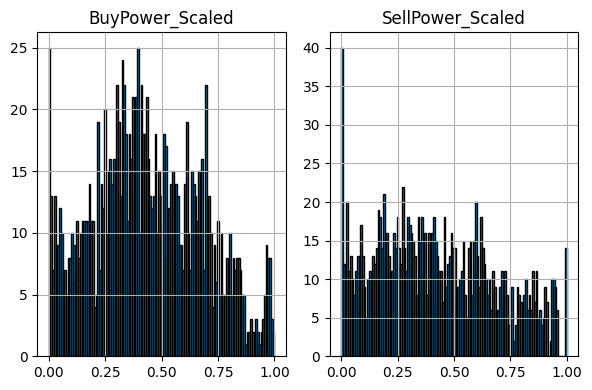

In [106]:
trading_data[['BuyPower_Scaled', 'SellPower_Scaled']].hist(figsize=(6,4), bins=130, edgecolor='black')
plt.tight_layout()
plt.show()

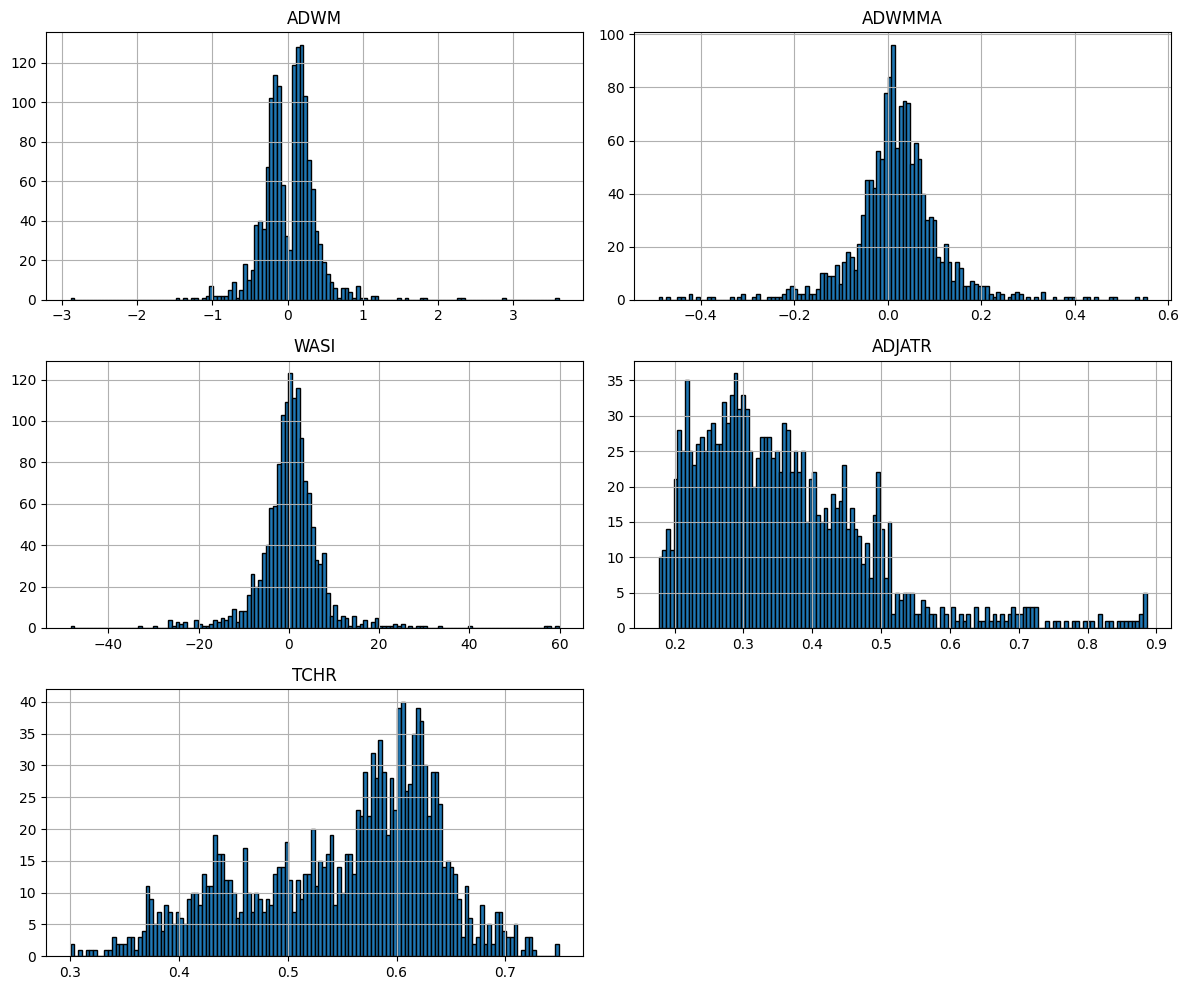

In [51]:
trading_data[raw_features_g2].hist(figsize=(12,10), bins=130, edgecolor='black')
plt.tight_layout()
plt.show()

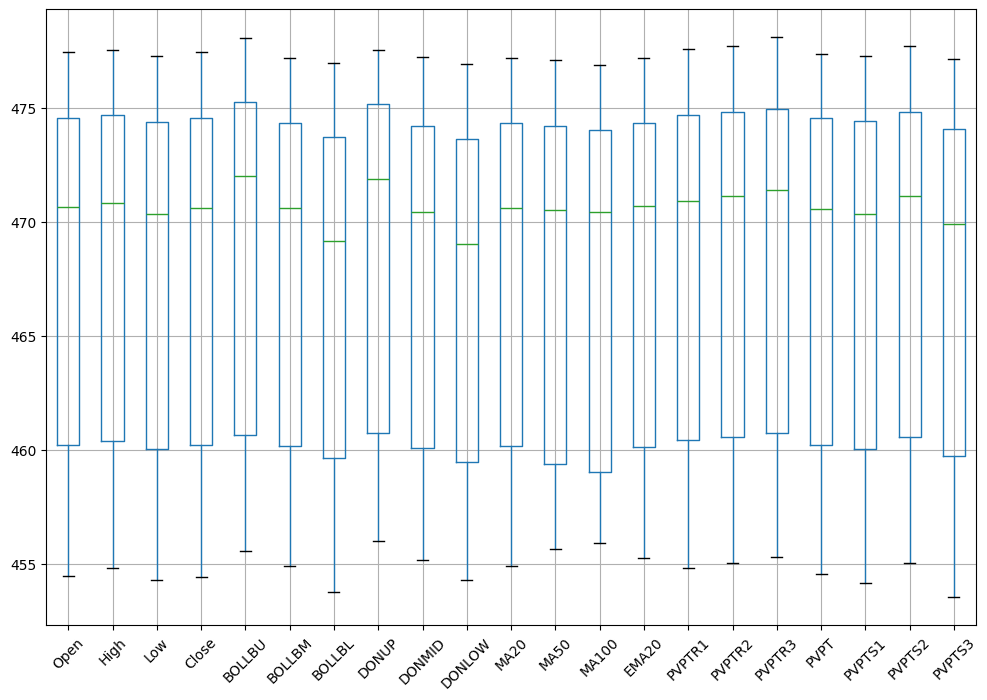

In [48]:
### Show box plots for all features g1
plt.figure(figsize=(12,8))
trading_data[raw_features_g1].boxplot(rot=45)
plt.show()

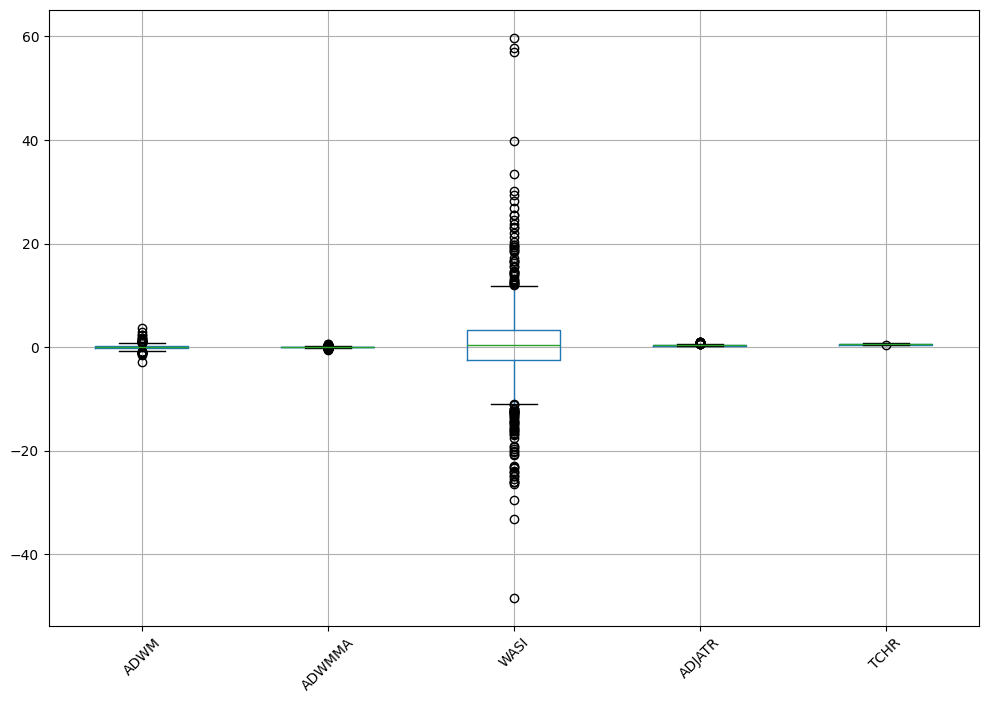

In [88]:
### Show box plots for all features g2
plt.figure(figsize=(12,8))
trading_data[raw_features_g2].boxplot(rot=45)
#trading_data[['ADWM', 'ADWMMA', 'ADJATR', 'TCHR']].boxplot(rot=45)
plt.show()



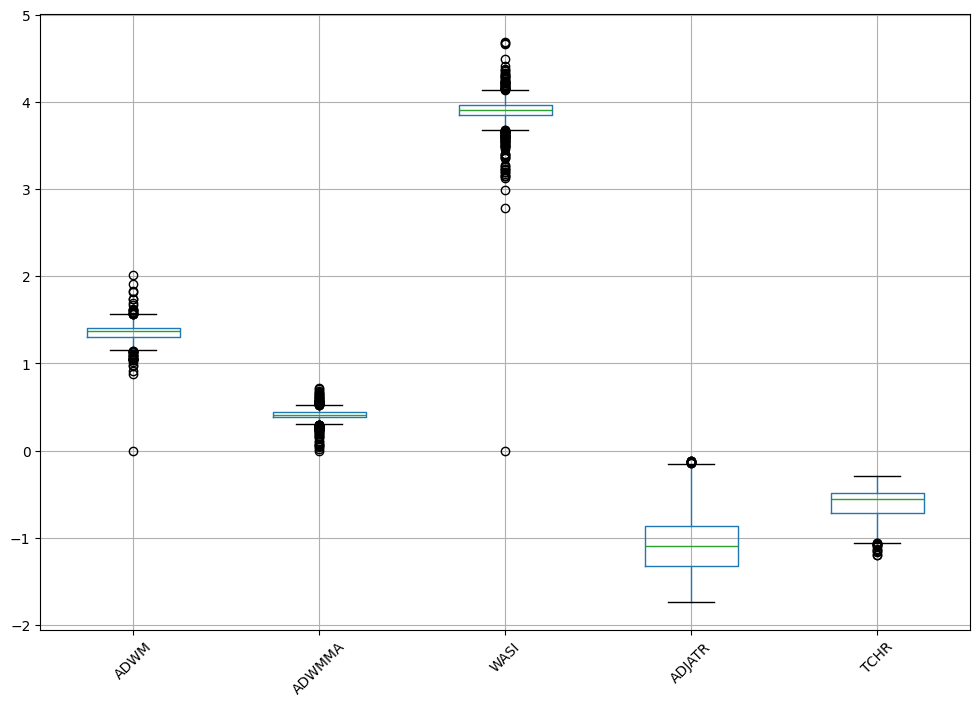

In [72]:
### TRy taking log of g2 features
min_values = trading_data[raw_features_g2].min()
shift_values = min_values[ min_values < 0].abs() + 1

trading_data_log = trading_data.copy()
for col in shift_values.index:
    trading_data_log[col] += shift_values[col]

trading_data_log[raw_features_g2] = trading_data_log[raw_features_g2].apply(np.log)

plt.figure(figsize=(12,8))
trading_data_log[raw_features_g2].boxplot(rot=45)
plt.show()

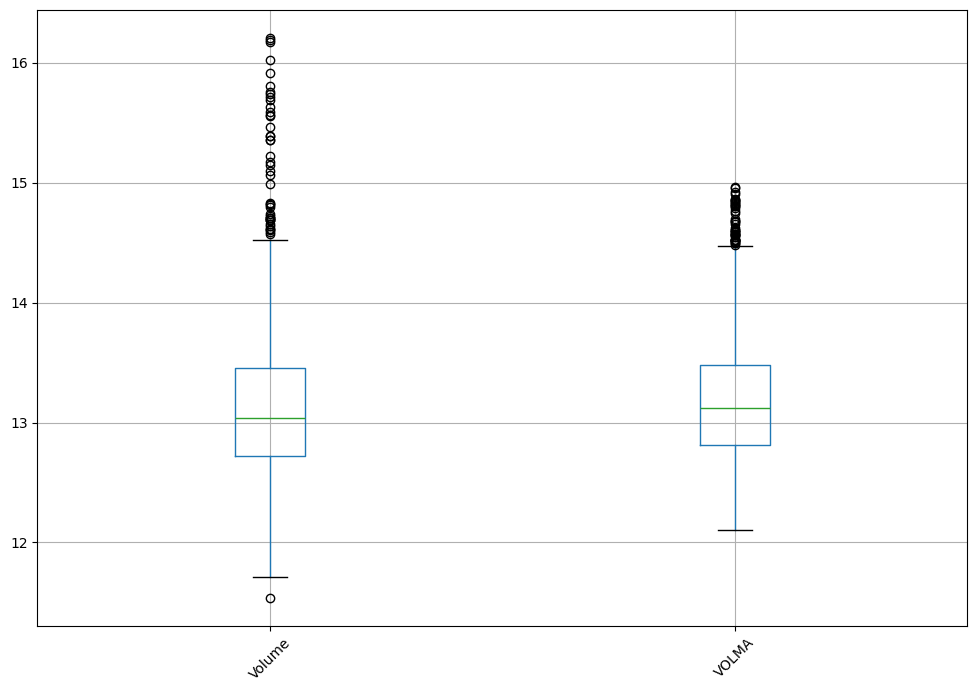

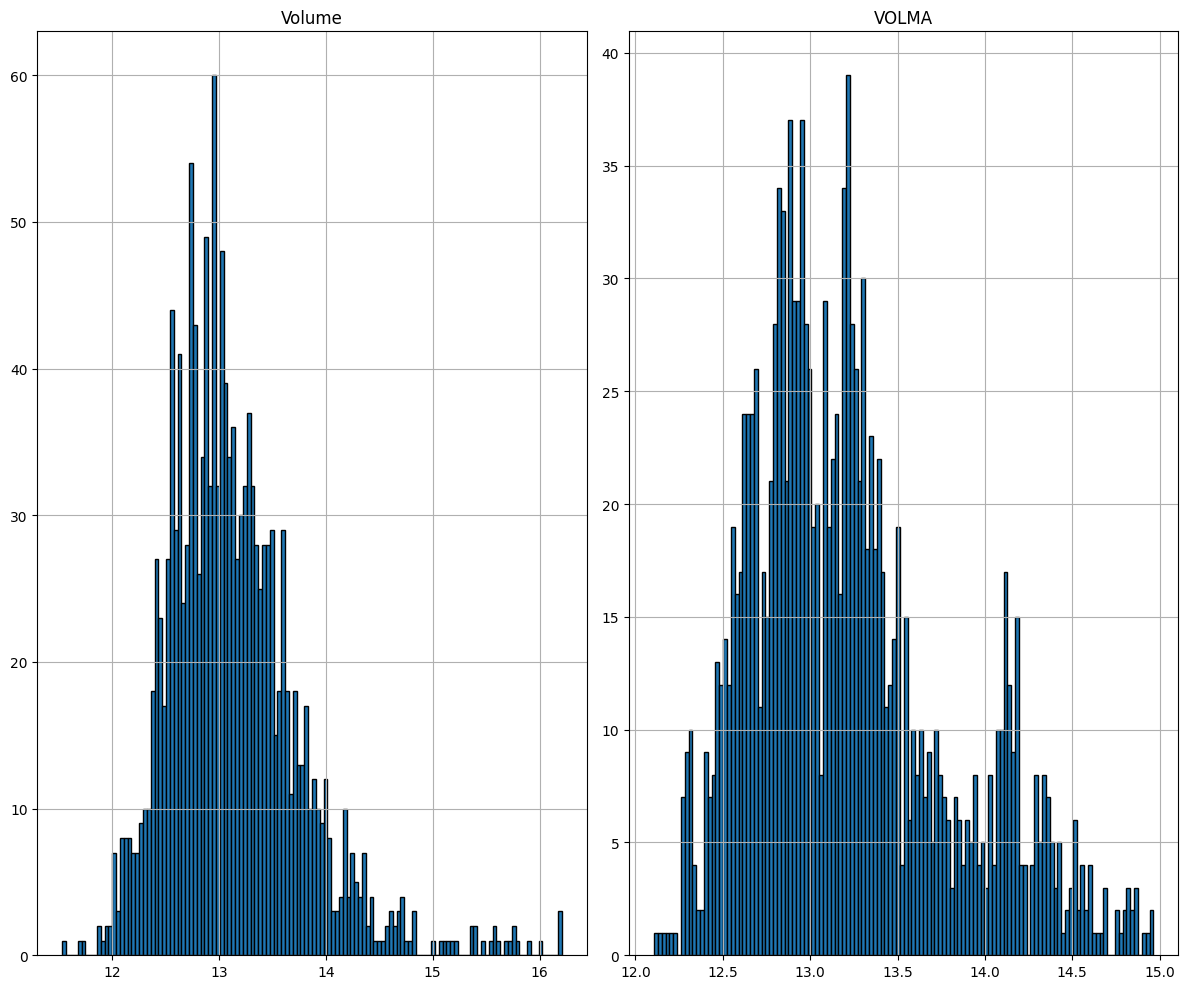

In [86]:
### DO EDA on G3 features
trading_data_log[raw_features_g3] = trading_data[raw_features_g3].apply(np.log)
plt.figure(figsize=(12,8))
trading_data_log[raw_features_g3].boxplot(rot=45)
plt.show()

trading_data_log[raw_features_g3].hist(figsize=(12,10), bins=130, edgecolor='black')
plt.tight_layout()
plt.show()

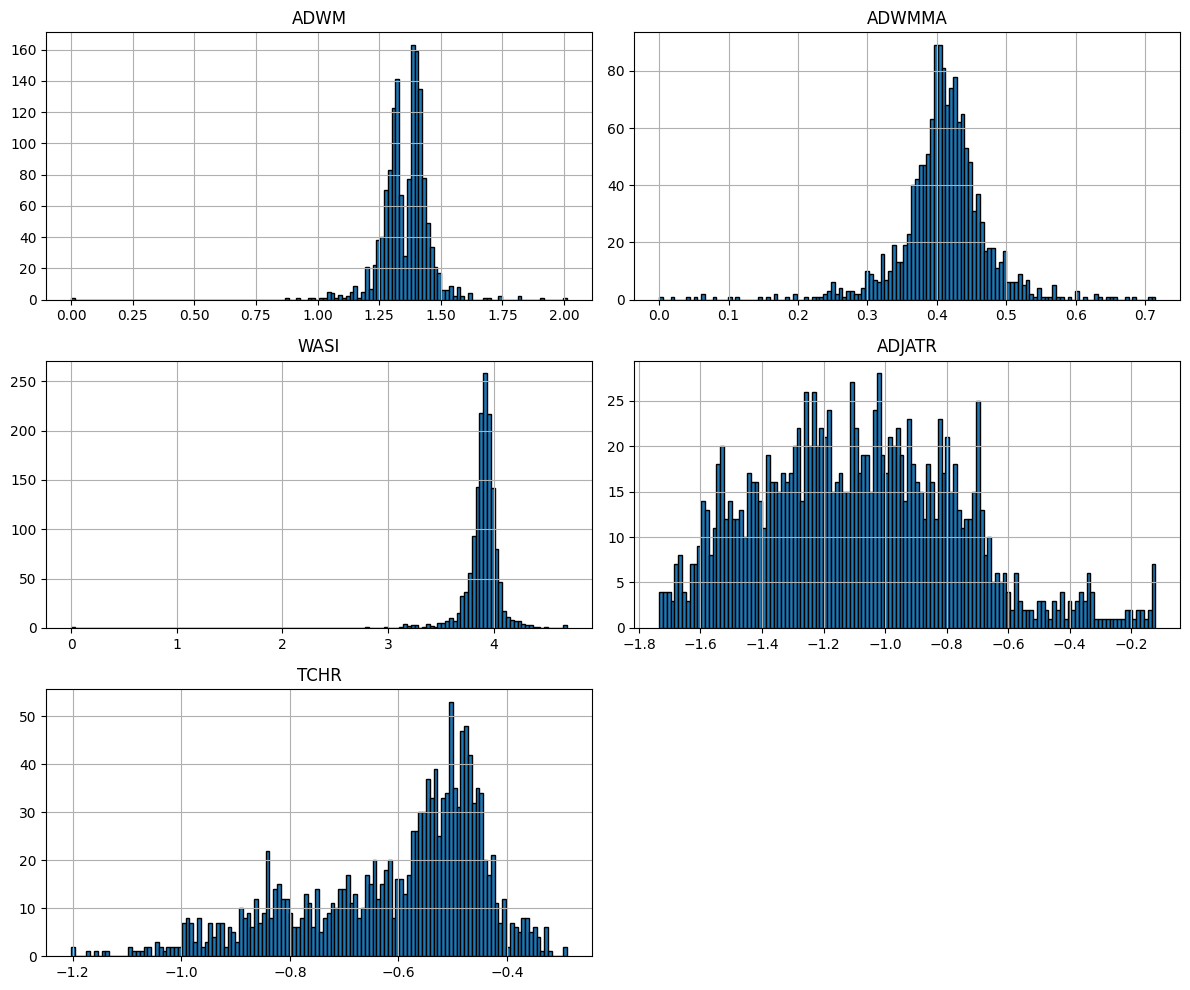

In [73]:
trading_data_log[raw_features_g2].hist(figsize=(12,10), bins=130, edgecolor='black')
plt.tight_layout()
plt.show()

In [82]:
real_cols = [f'fourier_real_{j+2}' for j in range(fourier_n_components-1)]
imag_cols = [f'fourier_imag_{j+2}' for j in range(fourier_n_components-1)]
mag_cols = [f'fourier_mag_{j+2}' for j in range(fourier_n_components-1)]



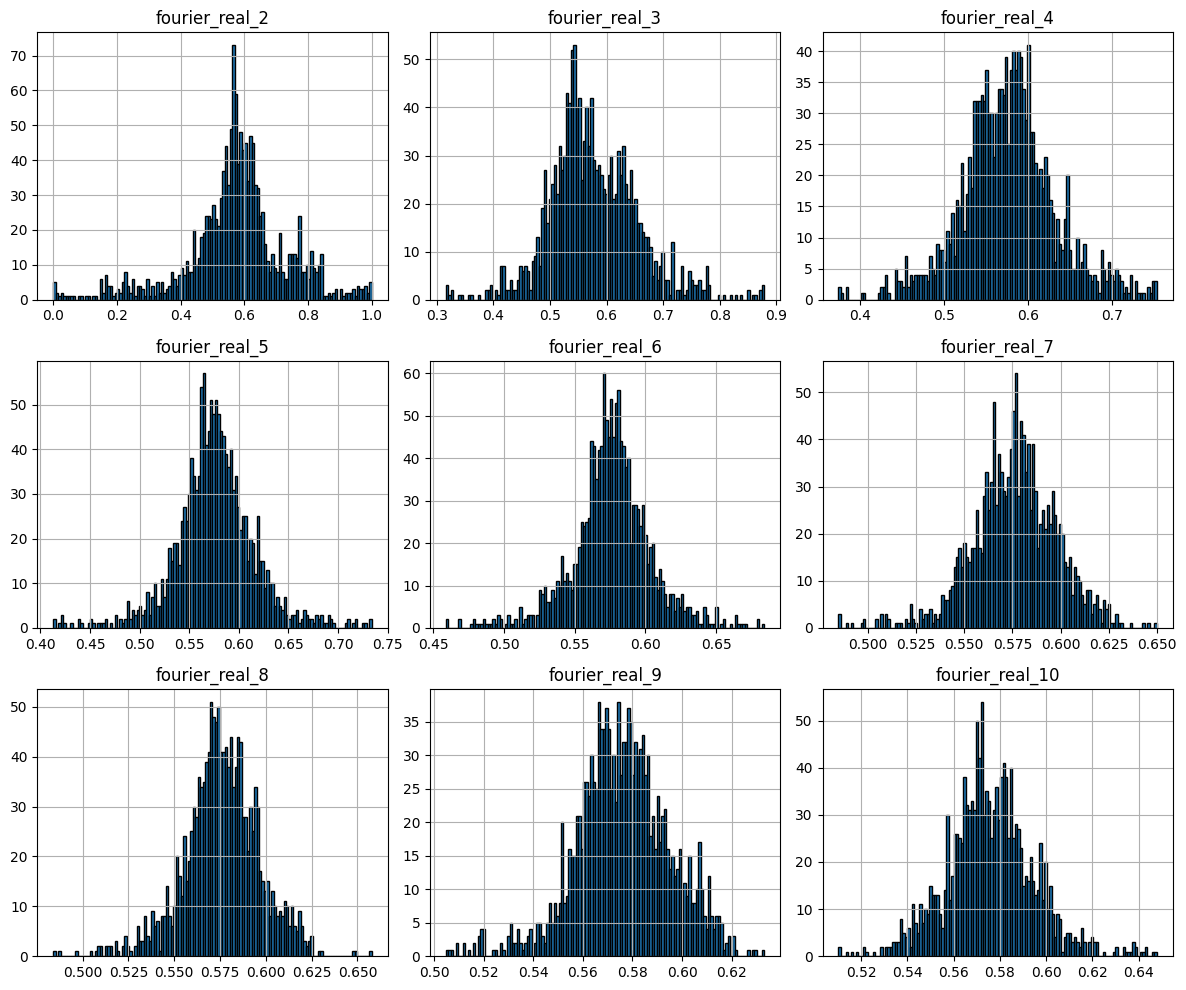

In [83]:
trading_data[real_cols].hist(figsize=(12,10), bins=130, edgecolor='black')
plt.tight_layout()
plt.show()

In [105]:
#trading_data['Date'] = pd.to_datetime(trading_data['Date'])
fig = go.Figure(data=[go.Candlestick(x=trading_data['Date'], open=trading_data['Open'], high=trading_data['High'], low=trading_data['Low'], close=trading_data['Close'])])
fig.update_layout(title='CandleStick Chart SPY', xaxis_title='Date', yaxis_title='Price', xaxis_rangeslider_visible=False, yaxis=dict(fixedrange=False), xaxis=dict(type='category'))
buy_signals = trading_data[trading_data['BuyPower_Scaled'] > 0.7]
sell_signals = trading_data[trading_data['SellPower_Scaled'] > 0.7]
fig.add_trace(go.Scatter(x=buy_signals['Date'], y=buy_signals['Low'], mode='markers', name='Buy Signal', marker=dict(color='blue', size=10)))
fig.add_trace(go.Scatter(x=sell_signals['Date'], y=sell_signals['High'], mode='markers', name='Sell Signal', marker=dict(color='yellow', size=10)))
fig.show()

In [116]:
def get_fourier_columns():
    return [f'fourier_real_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_imag_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_mag_{j+2}' for j in range(fourier_n_components-1)]   


In [123]:

def get_features(data, inference=False, scalers={}):
    
    # Define global variables
    global stand_scaler
    global raw_features_g1
    global raw_features_g2
    global raw_features_g3
    global raw_features_g4

    stand_features = config['stand_scale_features'].split(',')
    stand_features = [x for x in stand_features if x.strip()]
    robust_features = config['robust_scale_features'].split(',')
    robust_features = [x for x in robust_features if x.strip()]
    fourier_columns = get_fourier_columns()
    # need to use min max scaler for g1
    stand_features = stand_features + fourier_columns

    real_cols = [f'fourier_real_{j+2}' for j in range(fourier_n_components-1)]
    imag_cols = [f'fourier_imag_{j+2}' for j in range(fourier_n_components-1)]
    mag_cols = [f'fourier_mag_{j+2}' for j in range(fourier_n_components-1)]

    if inference:
        scaler = scalers['fourier_minmax']
        real_min, real_max = scaler['real_min'], scaler['real_max']
        imag_min, imag_max = scaler['imag_min'], scaler['imag_max']
        mag_min, mag_max = scaler['mag_min'], scaler['mag_max']

    else:
        real_min, real_max = data[real_cols].min().min(), data[real_cols].max().max()
        imag_min, imag_max = data[imag_cols].min().min(), data[imag_cols].max().max()
        mag_min, mag_max = data[mag_cols].min().min(), data[mag_cols].max().max()
        fourier_min_max = {
                    'real_min': real_min, 'real_max': real_max,
                    'imag_min': imag_min, 'imag_max': imag_max,
                    'mag_min': mag_min,'mag_max': mag_max,
                    }
        with open(f'../{config['fourier_minmax_path']}', 'wb'):
            pickle.dump(fourier_min_max, f)
    
    
    data[real_cols] = (data[real_cols] - real_min) / (real_max - real_min)
    data[imag_cols] = (data[imag_cols] - imag_min) / (imag_max - imag_min)
    data[mag_cols] = (data[mag_cols] - mag_min) / (mag_max - mag_min)

    # Apply standard scaler to g2
    #print("Before standard scaler")
    if inference:
        scaler = scalers['stand']
        data[stand_features] = scaler.transform(data[stand_features])
    else:
        scaler = StandardScaler()
        data[stand_features] = scaler.fit_transform(data[stand_features])
        #print("After standard scaler")

        with open(f'../{config['stand_scaler_path']}', 'wb') as f:
            pickle.dump(scaler, f)
    

    # Apply robust scaler
    if inference:
        scaler = scalers['robust']
        data[robust_features] = scaler.transform(data[robust_features])

    else:
        scaler = RobustScaler()
        data[robust_features] = scaler.fit_transform(data[robust_features])

        with open(f'../{config['robust_scaler_path']}', 'wb') as f:
            pickle.dump(scaler, f)
  

    return data


In [117]:
fourier_columns = get_fourier_columns()

#all_feature_columns = raw_features_g1 + raw_features_g2 + raw_features_g3 + raw_features_g4 + fourier_columns + ['DayofWeek']
all_feature_columns = raw_features_g1 + raw_features_g2 + raw_features_g3 + raw_features_g4 + fourier_columns

print(all_feature_columns)


['Open', 'High', 'Low', 'Close', 'BOLLBU', 'BOLLBM', 'BOLLBL', 'DONUP', 'DONMID', 'DONLOW', 'MA20', 'MA50', 'MA100', 'EMA20', 'PVPTR1', 'PVPTR2', 'PVPTR3', 'PVPT', 'PVPTS1', 'PVPTS2', 'PVPTS3', 'ADWM', 'ADWMMA', 'WASI', 'ADJATR', 'TCHR', 'Volume', 'VOLMA', 'Sine_TimeOfDay', 'Cosine_TimeOfDay', 'fourier_real_2', 'fourier_real_3', 'fourier_real_4', 'fourier_real_5', 'fourier_real_6', 'fourier_real_7', 'fourier_real_8', 'fourier_real_9', 'fourier_real_10', 'fourier_imag_2', 'fourier_imag_3', 'fourier_imag_4', 'fourier_imag_5', 'fourier_imag_6', 'fourier_imag_7', 'fourier_imag_8', 'fourier_imag_9', 'fourier_imag_10', 'fourier_mag_2', 'fourier_mag_3', 'fourier_mag_4', 'fourier_mag_5', 'fourier_mag_6', 'fourier_mag_7', 'fourier_mag_8', 'fourier_mag_9', 'fourier_mag_10']


In [131]:
trading_data_full = get_features(trading_data.copy())
trading_data_full = trading_data_full.dropna()
#trading_features = trading_data_full[all_feature_columns]
#trading_labels = trading_data_full['Label']

In [112]:
print(trading_data_full[all_feature_columns].shape)

(1437, 60)


In [114]:
trading_data_full.dropna(inplace=True)
trading_data_full.describe().T

C:\Users\coool\AppData\Local\Temp\ipykernel_11228\249046272.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,count,mean,min,25%,50%,75%,max,std
Date,1437,2023-12-16 13:00:21.920667904,2023-12-04 11:15:00,2023-12-08 15:10:00,2023-12-15 12:35:00,2023-12-22 10:00:00,2023-12-29 13:55:00,NaN
Open,1437.0,-0.016773,-1.787119,-1.024541,0.343555,0.876892,1.289927,1.000127
High,1437.0,-0.016882,-1.765471,-1.02278,0.356886,0.878777,1.278893,1.000017
Low,1437.0,-0.016771,-1.782648,-1.019593,0.339474,0.880027,1.289618,1.000128
Close,1437.0,-0.016796,-1.791301,-1.024266,0.341284,0.879613,1.289546,1.000103
Volume,1437.0,0.5353,-0.98371,-0.346595,-0.010407,0.628848,28.33025,2.280888
BOLLBU,1437.0,-0.015737,-1.721853,-1.050362,0.444553,0.878582,1.265444,1.001158
BOLLBM,1437.0,-0.016468,-1.704139,-1.041281,0.368121,0.871445,1.267167,1.000434
BOLLBL,1437.0,-0.01705,-1.73637,-1.021136,0.302003,0.90931,1.346026,0.999828
DONUP,1437.0,-0.015894,-1.672089,-1.073805,0.42824,0.887124,1.204608,1.001002


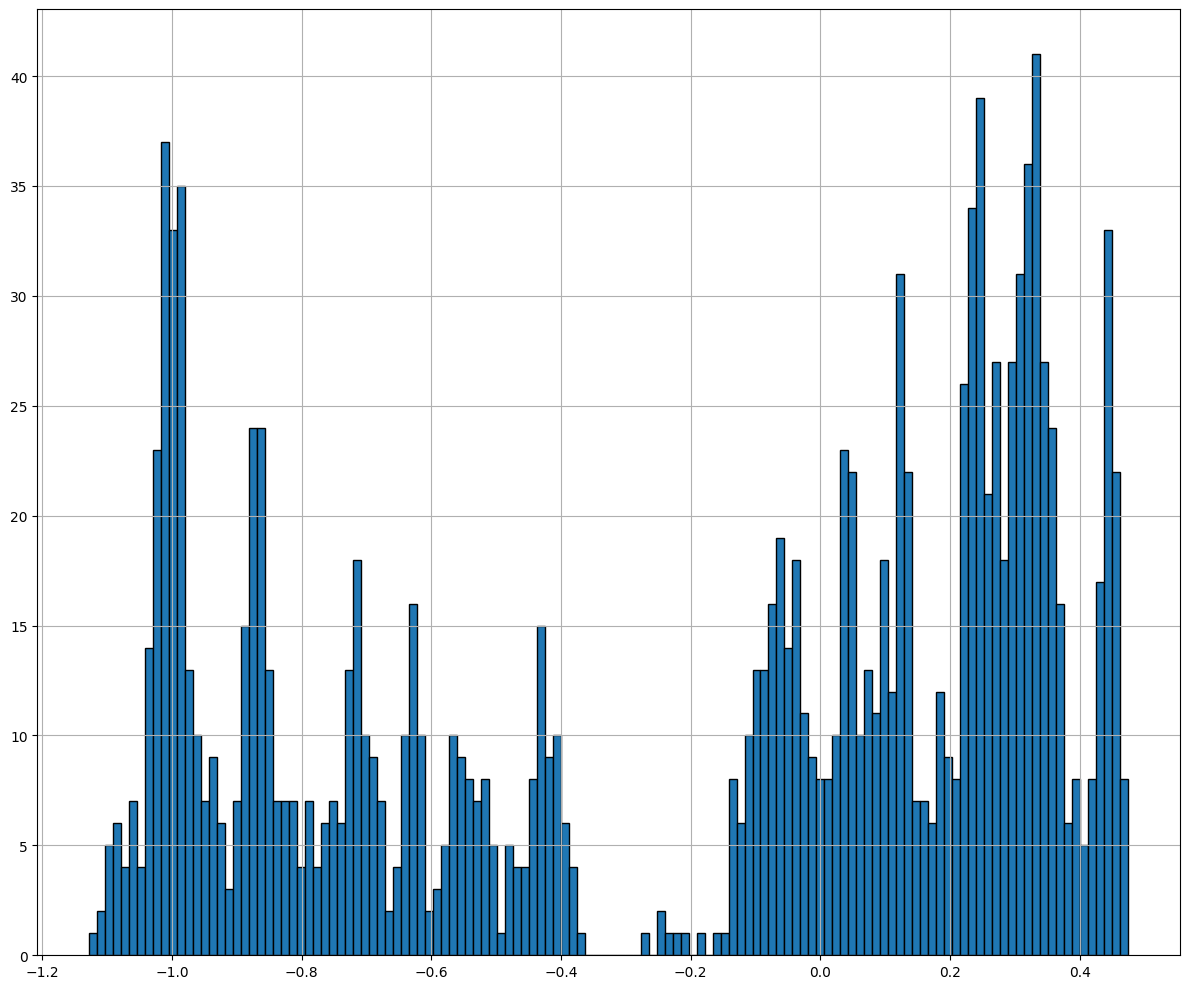

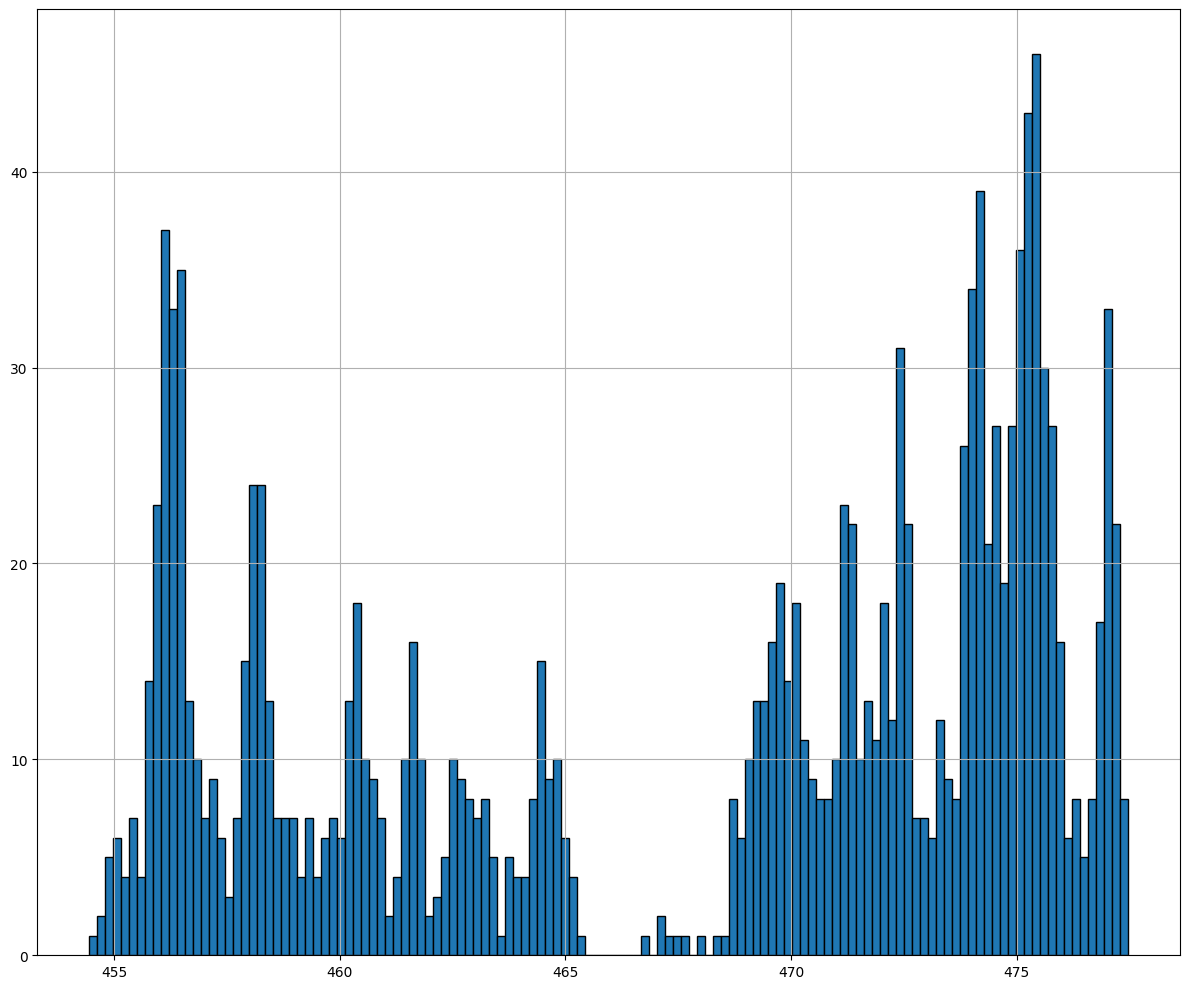

In [132]:
trading_data_full['Open'].hist(figsize=(12,10), bins=130, edgecolor='black')
plt.tight_layout()
plt.show()

trading_data['Open'].hist(figsize=(12,10), bins=130, edgecolor='black')
plt.tight_layout()
plt.show()

In [134]:

label_column_names = ['BuyPower_Scaled', 'SellPower_Scaled']
#assert trading_features.shape[0] == trading_labels.shape[0], "Mismatch between features and labels length"
X = trading_data_full[all_feature_columns]
y = trading_data_full[label_column_names]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=46)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=46)


In [135]:


#convert data to d matrix to use with xgb
enab_cat = True
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=enab_cat )
dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=enab_cat)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
dtrain_valid = xgb.DMatrix(data = pd.concat([X_train, X_valid]),label=pd.concat([y_train, y_valid]), enable_categorical=enab_cat)



In [139]:
num_boosting_rounds = 5000

In [140]:

##### Implement initial training of the model   
learning_rate = 0.3
starting_tree_method = 'approx'
#metric can be mlogloss, auc, merror etc
metric = 'rmse'

base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': metric
}

params = {
    'learning_rate': learning_rate,
    'tree_method': starting_tree_method
}

params.update(base_params)

model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boosting_rounds, evals=[(dtrain, 'train')], early_stopping_rounds=50)

[0]	train-rmse:0.20864
[1]	train-rmse:0.17391
[2]	train-rmse:0.14668
[3]	train-rmse:0.12447
[4]	train-rmse:0.11083
[5]	train-rmse:0.09921
[6]	train-rmse:0.08688
[7]	train-rmse:0.07792
[8]	train-rmse:0.07053
[9]	train-rmse:0.06474
[10]	train-rmse:0.05995
[11]	train-rmse:0.05674
[12]	train-rmse:0.05328
[13]	train-rmse:0.05066
[14]	train-rmse:0.04781
[15]	train-rmse:0.04382
[16]	train-rmse:0.04148
[17]	train-rmse:0.03990
[18]	train-rmse:0.03681
[19]	train-rmse:0.03435
[20]	train-rmse:0.03183
[21]	train-rmse:0.02955
[22]	train-rmse:0.02867
[23]	train-rmse:0.02697
[24]	train-rmse:0.02542
[25]	train-rmse:0.02492
[26]	train-rmse:0.02421
[27]	train-rmse:0.02310
[28]	train-rmse:0.02225
[29]	train-rmse:0.02119
[30]	train-rmse:0.02028
[31]	train-rmse:0.01955
[32]	train-rmse:0.01870
[33]	train-rmse:0.01789
[34]	train-rmse:0.01711
[35]	train-rmse:0.01631
[36]	train-rmse:0.01551
[37]	train-rmse:0.01489
[38]	train-rmse:0.01442
[39]	train-rmse:0.01398
[40]	train-rmse:0.01337
[41]	train-rmse:0.01273
[4

In [141]:
##### CReate the objective function for optuna to tune tree parameters

def objective(trial):
    params = {
        'tree_method' : trial.suggest_categorical('tree_method', ['approx', 'hist']) , 
        'gamma': trial.suggest_float('gamma', 1e-2, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.1, 25), 
        'alpha': trial.suggest_float('alpha', 0.001, 10),
    }
    params.update(base_params)
    #thresholds = [trial.suggest_float(f'threshold_{i}', 0.1, 0.9) for i in ]
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'valid-{metric}')

    xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boosting_rounds, 
                          evals=[(dtrain, 'train'),(dvalid, 'valid')],
                          early_stopping_rounds=50,
                          verbose_eval=0,
                          callbacks=[pruning_callback])
    trial.set_user_attr('best_iteration', xgb_model.best_iteration)
    #xgb.XGBClassifier(**params, random_state=46, early_stopping_rounds=30, objective='multi:softprob', lambda_=config['lam'], alpha=config['alpha'], n_estimators=100)
    #xgb_model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)])

    y_pred = xgb_model.predict(dvalid)
    rmse_buy = mean_squared_error(y_valid['BuyPower_Scaled'], y_pred[:, 0]) ** 0.5
    rmse_sell = mean_squared_error(y_valid['SellPower_Scaled'], y_pred[:, 1]) ** 0.5

    return (rmse_buy + rmse_sell) / 2

In [142]:

study = optuna.create_study(direction='minimize') # for metric auc its maximuze, and for mlogloss its minimie

study.optimize(objective, n_trials=50)

# Get the best parameters
print(f" Best parameters: {study.best_params}")
print(f" Best Accuracy: {study.best_value}")

[I 2025-02-03 13:14:55,009] A new study created in memory with name: no-name-61fce434-0adf-4e36-82a1-199f97bef0c4
[I 2025-02-03 13:14:55,284] Trial 0 finished with value: 0.2587315625193515 and parameters: {'tree_method': 'hist', 'gamma': 4.575897698209835, 'max_depth': 5, 'min_child_weight': 135.72862568011791, 'subsample': 0.2028859756017099, 'colsample_bytree': 0.7823229362734094, 'lambda': 24.667014916167595, 'alpha': 4.245904436683505}. Best is trial 0 with value: 0.2587315625193515.
[I 2025-02-03 13:14:55,377] Trial 1 finished with value: 0.25840544128477294 and parameters: {'tree_method': 'approx', 'gamma': 6.6198649604100295, 'max_depth': 8, 'min_child_weight': 215.62711252273252, 'subsample': 0.974524925128984, 'colsample_bytree': 0.5656064338808295, 'lambda': 6.487441500408524, 'alpha': 8.919769811926853}. Best is trial 1 with value: 0.25840544128477294.
[I 2025-02-03 13:14:55,487] Trial 2 finished with value: 0.2584615163757633 and parameters: {'tree_method': 'approx', 'gamm

 Best parameters: {'tree_method': 'approx', 'gamma': 0.02401379750523383, 'max_depth': 3, 'min_child_weight': 27.28189826244594, 'subsample': 0.8670962637916299, 'colsample_bytree': 0.6435234569030818, 'lambda': 5.04416911223964, 'alpha': 5.457534732868475}
 Best Accuracy: 0.17508414534110234


In [143]:
best_params = study.best_params
best_params

{'tree_method': 'approx',
 'gamma': 0.02401379750523383,
 'max_depth': 3,
 'min_child_weight': 27.28189826244594,
 'subsample': 0.8670962637916299,
 'colsample_bytree': 0.6435234569030818,
 'lambda': 5.04416911223964,
 'alpha': 5.457534732868475}

In [144]:
low_learning_rate = 0.01

params = {}
params.update(base_params)
params.update(study.best_params)
params['learning_rate'] = low_learning_rate

model_stage2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boosting_rounds, 
                         evals=[(dtrain, 'train'), (dvalid, 'valid')], 
                         early_stopping_rounds=50,
                         verbose_eval=0)

In [145]:
model_stage2.best_iteration # got the best iteration from stage 2 training

1638

In [146]:
model_final = xgb.train(params=params, dtrain=dtrain_valid,
                        num_boost_round = model_stage2.best_iteration,
                        verbose_eval=0)

In [565]:
model_path = f'../Saved_Data/{config['model_save_name']}'
model_final.save_model(model_path)

In [150]:
y_pred_test = model_final.predict(dtest)

y_pred_buy = y_pred_test[:, 0]

y_pred_sell = y_pred_test[:, 1]

metrics = {
    "RMSE (Buy Power)": mean_squared_error( y_test['BuyPower_Scaled'], y_pred_buy),
    "RMSE (Sell Power)": mean_squared_error(y_test['SellPower_Scaled'], y_pred_sell),
}

df_metrics = pd.DataFrame(metrics.items(), columns=["Metric", "Value"])

print(df_metrics)


              Metric     Value
0   RMSE (Buy Power)  0.022340
1  RMSE (Sell Power)  0.030043


In [569]:
'''
with open('../Saved_Data/minmax_scaling_params.json', 'r') as f:
    minmax_scaling_params = json.load(f)

# Load standard scaler
with open('../Saved_Data/g2_standard_scaler.pkl', 'rb') as f:
    stand_scaler = pickle.load(f)

with open('../Saved_Data/label_encoder.pkl', 'rb') as f:
    loaded_label_encoder = pickle.load(f)
'''

In [570]:
## Load the new data to run inference
#new_data = pd.read_excel(config['data_excel_path'], sheet_name='TestNew')
new_data_start_date = pd.to_datetime('2024-01-01')
new_data_end_date = pd.to_datetime('2024-12-31')
new_data = all_trading_data[(all_trading_data['Date'] >= new_data_start_date) & (all_trading_data['Date'] <= new_data_end_date)]
new_data = new_data.reset_index(drop=True)

In [571]:
new_data.head()

,Date,Symbol,Open,High,Low,Close,Volume
0,2024-01-02 09:30:00,SPY,472.160,472.80,472.05,472.67,2339778
1,2024-01-02 09:35:00,SPY,472.670,472.74,471.88,471.92,1574945
2,2024-01-02 09:40:00,SPY,471.920,472.10,471.71,471.80,1634708
3,2024-01-02 09:45:00,SPY,471.790,472.09,471.39,471.39,1398881
4,2024-01-02 09:50:00,SPY,471.395,471.95,471.36,471.42,1396561


In [572]:
bolband_period = config['bolband_period']
donchn_period = config['donchn_period']
max_MA_period = 100
max_EMA_period = 20
tchr_period = config['tchr_period']
adwm_period = config['adwm_period']
atr_period = config['atr_period']
volume_ma_period = config['volume_ma_period']
print(f" Fourier window : {fourier_lookback_window}")
max_window = max(bolband_period, 
                 donchn_period, 
                 max_MA_period, 
                 max_EMA_period,
                 tchr_period,
                 adwm_period,
                 atr_period,
                 volume_ma_period, fourier_lookback_window)


 Fourier window : 100


In [573]:
def process_data(raw_data):
    trades = []
    balance = 0
    profit_amount = 10
    profit_count = 0
    loss_count = 0
    loss_amount = profit_amount * config['risk']
    trading_signals = pd.DataFrame(columns=['Date','High', 'Low', 'Open', 'Close', 'Signal'])
    thres_opt = config['use_threshold_optimization']
    print(f"Use threshold optimization : {thres_opt}")
                                   
    global label_encoder
    # This is the dataframe to which we will be adding the rows live
    historical_data = pd.DataFrame(columns=['Date','High', 'Low', 'Open', 'Close', 'Volume'])
    numeric_columns = ['High', 'Low', 'Open', 'Close', 'Volume'] 
    historical_data[numeric_columns] = historical_data[numeric_columns].apply(pd.to_numeric)
    predictions = []
    for index,row in raw_data.iterrows():
        #print(f'volume : {row['Volume']}')
        if index % 100 == 0:
            print(f'Index : {index}')
        if index > 2000:
            break
        new_row = pd.DataFrame({'Date': [row['Date']], 'High': [row['High']], 'Low': [row['Low']], 'Open': [row['Open']], 'Close': [row['Close']], 'Volume': [row['Volume']]})
        signal_row = pd.DataFrame({'Date': [row['Date']], 'High': [row['High']], 'Low': [row['Low']], 'Open': [row['Open']], 'Close': [row['Close']], 'Signal': ['N']})
        trading_signals = pd.concat([trading_signals, signal_row], ignore_index=True)
        historical_data = pd.concat([historical_data, new_row], ignore_index=True)
        historical_data['Volume'] = historical_data['Volume'].astype(int)
        #print(historical_data['Volume'])
        #print(f'historical data length : {len(historical_data)}')
        if len(historical_data) > max_window:
            #print(f"At index : {index}")
            #print(f"length of historical data : {len(historical_data)} , so splicing")
            historical_data = historical_data.iloc[-max_window:].reset_index(drop=True)
            #print(f"Now lenngth : {len(historical_data)} and max window : {max_window}")
            
        if len(historical_data) >= max_window:
            updated_data = add_new_features_df(historical_data.copy())
            #print("Historical data 1 : ")
            #print(historical_data[['Volume']].tail())
            #last_row_to_print = historical_data.iloc[[-1]]
            #for column, value in last_row_to_print.items():
            #    print(f'{column} : {value}')
            #updated_data.info()
            inf_features = get_features(updated_data.copy(), inference=True)
            #print("Historical data 2 : ")
            #print(historical_data[['Volume']].tail())
            last_row_features = inf_features.iloc[[-1]]
            last_row_features = last_row_features[all_feature_columns]
            if last_row_features.isna().any().any():
                print(f'The inference row at index : {index} contains na')
                #last_row_to_print = updated_data.iloc[[-1]]
                #for column, value in last_row_to_print.items():
                #    print(f'{column} : {value}')
                print(historical_data[['Volume']].tail())
                break
                continue
        
            last_row_dm = xgb.DMatrix(last_row_features, enable_categorical=True)
            prob_prediction = model_final.predict(last_row_dm)
            if thres_opt:
                prob_prediction_final = np.zeros_like(prob_prediction)
                for class_idx, threshold in enumerate(best_thresholds.values()):
                    prob_prediction_final[:, class_idx] = (prob_prediction[:, class_idx] > threshold).astype(int)

                predicted_class_index = np.argmax(prob_prediction_final, axis=1)  
            else:
                predicted_class_index = np.argmax(prob_prediction, axis=1)  
            #predicted_class_index = np.argmax(prob_prediction, axis=1)
            prediction = label_encoder.inverse_transform(predicted_class_index)
            #print(f'Prediction : {prediction}')
            trading_signals.loc[trading_signals.index[-1], 'Signal'] = prediction[0]
            predictions.append(prediction[0])
            for trade in trades:
                if (trade['Type'] == 'B' and row['High'] >= trade['TakeProfit']) or (trade['Type'] == 'S' and row['Low'] <= trade['TakeProfit']):
                    trade['Active'] = 'N'
                    balance += profit_amount
                    profit_count += 1
                    print(f"Profit, New Balance : {balance}")
                elif (trade['Type'] == 'B' and row['Low'] <= trade['StopLoss']) or (trade['Type'] == 'S' and row['High'] >= trade['StopLoss']):
                    trade['Active'] = 'N'
                    balance -= loss_amount
                    loss_count += 1
                    print(f"Loss, New Balance : {balance}")
            
            # Filter out all trades that are not active
            trades = [trade for trade in trades if trade['Active'] == 'Y']
            
            if len(trades) == 0:
                if prediction[0] == 'B':
                    take_profit = updated_data.iloc[-1]['Take_Profit_Level'] 
                    trades.append({"Type": "B", 
                                "TakeProfit": row['Close'] + take_profit,
                                "StopLoss": row['Close'] - (take_profit * config['risk']),
                                "Active": "Y"
                                })
                elif prediction[0] == 'S':
                    take_profit = updated_data.iloc[-1]['Take_Profit_Level'] 
                    trades.append({"Type": "S", 
                                "TakeProfit": row['Close'] - take_profit,
                                "StopLoss": row['Close'] + (take_profit * config['risk']),
                                "Active": "Y"
                                })
        


    #print(f' Predictions : {predictions}')
    counts = pd.Series(predictions).value_counts()
    print(counts)
    print(f"Final Balance : {balance} \n Profit count : {profit_count} \n Loss count : {loss_count}")
    
    return trading_signals

            

        
    

In [574]:
new_data.isna().any(axis=1).sum()

np.int64(0)

In [555]:
print(volume_ma_period)

10


In [575]:
new_data.shape[0]

19473

In [576]:
tr_signals = process_data(new_data)


Use threshold optimization : True
Index : 0


C:\Users\coool\AppData\Local\Temp\ipykernel_16456\1673387868.py:26: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

C:\Users\coool\AppData\Local\Temp\ipykernel_16456\1673387868.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Index : 100
Index : 200
Index : 300
Loss, New Balance : -5.0
Index : 400
Index : 500
Index : 600
Index : 700
Index : 800
Index : 900
Index : 1000
Index : 1100
Loss, New Balance : -10.0
Index : 1200
Profit, New Balance : 0.0
Index : 1300
Index : 1400
Index : 1500
Profit, New Balance : 10.0
Index : 1600
Index : 1700
Index : 1800
Index : 1900
Index : 2000
H    1892
S       9
B       1
Name: count, dtype: int64
Final Balance : 10.0 
 Profit count : 2 
 Loss count : 2


In [577]:
#trading_data['Date'] = pd.to_datetime(trading_data['Date'])
fig = go.Figure(data=[go.Candlestick(x=tr_signals['Date'], open=tr_signals['Open'], high=tr_signals['High'], low=tr_signals['Low'], close=tr_signals['Close'])])
fig.update_layout(title='CandleStick Chart Trading Signals SPY', xaxis_title='Date', yaxis_title='Price', xaxis_rangeslider_visible=False, yaxis=dict(fixedrange=False), xaxis=dict(type='category'))
buy_signals = tr_signals[tr_signals['Signal'] == 'B']
sell_signals = tr_signals[tr_signals['Signal'] == 'S']
fig.add_trace(go.Scatter(x=buy_signals['Date'], y=buy_signals['Low'], mode='markers', name='Buy Signal', marker=dict(color='blue', size=10)))
fig.add_trace(go.Scatter(x=sell_signals['Date'], y=sell_signals['High'], mode='markers', name='Sell Signal', marker=dict(color='yellow', size=10)))
fig.show()

In [ ]:
def simulate_returns_trading_signal(ts_df):
    